# The ROOT file

* With ROOT, objects can be written to files

* ROOT provides its own file class, [TFile](https://root.cern/doc/master/classTFile.html), to interact with these files

* ROOT files are _binary_ and can be transparently _compressed_ to reduce disk usage

* ROOT files have a logical “file-system-like” structure

  * E.g. a directory hierarchy


This is how you create a `TFile`:

In [ ]:
TFile * f = new TFile("my_file.root", "RECREATE")

<img src="img/tfile1.png">

and how you close it (note that when `f` is destroyed, the file is closed automatically):

In [ ]:
f->Close()

- The file we've just created is empty, let's actually write something in it this time.

- We will write a histogram object in it. 

- Note how we create the histogram after creating the file, we write the histogram and we finally close the file.

In [ ]:
TFile * f = new TFile("my_file.root", "RECREATE");
auto hist = new TH1F("my_histo", "Example histogram", 100, -4, 4);
f->cd();
hist->Write();
f->Close();

# Read a file

Let's open a file `data/hsimple.root` and plot histograms from it


In [ ]:
TFile inputfile("data/hsimple.root");   
inputfile.ls();

Add `%jsroot on` for pretty and interactive drawing 

In [ ]:
%jsroot on

In [ ]:

// Get the histograms and the profile from the file
auto hpx = (TH1F*)inputfile.Get("hpx"); // 
auto hpxpy = (TH2F*)inputfile.Get("hpxpy");
auto hprof = (TProfile*)inputfile.Get("hprof");


// Create a canvas and divide it
TCanvas *can = new TCanvas("can","A Simple Graph Example",1200,500);
can->Divide(3,1); // 3 columns, 1 row

can->cd(1);
hpx->Draw();

can->cd(2);
hpxpy->Draw("colz");

can->cd(3);
hprof->Draw();
can->Draw();

# Trees


## The HEP dataset

High Energy Physics data is made of many statistically independent collision events. 

Laying data into an "event class", then serialise and write out `N` instances of the class into a file would be very inefficient. 

In ROOT, a dataset is organised columns that can store elements of any C++ type:
* fundamental types: `int`, `float`
* C++ standard collections: `std::vector`, `std::map`
* User created C++ classes

The ROOT dataset is represented by the `TTree` class and is often simply called a tree. Columns in the dataset are instances of the `TBranch` class (often referred to as "branches").

<img src="img/dataset.png">

- A `TTree` dataset can be written to a `TFile` (just like any other C++ object). 

- The ROOT format is logically and physically (on disk) a columnar format. 

- Different columns can be read from disk independently. 

- This translates into faster IO performance with respect to other dataset formats (HDF5, SQL).

In [ ]:
TTree *tree = (TTree*)inputfile.Get("ntuple");
cout << "Number of entries in the tree: " << tree->GetEntries() << endl;
tree->Show(0);
tree->Show(20);

There are many ways to access the data in the tree

### 1. Using the TTree::Draw method (fast check distributions)

In [ ]:
can->cd(); // Go back to the main canvas
tree->Draw("px");
can->Draw();


In [ ]:
// if want to specify  a histogram to fill and operate on later
TH1D *hist1 = new TH1D("hist1","",100,-5,5);
tree->Draw("px>>hist1");
hist1->Draw();
can->Draw();

We can also apply some cuts on data

In [ ]:
tree->Draw("px","pz>1");
can->Draw();

Suitable for 2D as well, with draw option on third place, and maximum number of entries on the last place

In [ ]:
TH2D *hist2 = new TH2D("hist2","hist 2;px;pz",50,-3,3,50,0,10);
Int_t nEntryStop = 2000;
tree->Draw("pz:px>>hist2","","colz",nEntryStop); 
can->Draw();

### 2. Using the TTree::GetEntry method (old method, but everyone is still using it)

[TTreeReaderArray](https://root.cern/doc/master/classTTreeReader.html) also falls under the current category, the style is very similar.

In [ ]:

Float_t px, py, pz;
tree->SetBranchAddress("px", &px);
tree->SetBranchAddress("py", &py);
tree->SetBranchAddress("pz", &pz);

Int_t nEntries = tree->GetEntries();

for (int i=0; i<5; i++) {
    tree->GetEntry(i); //each time you call GetEntry, the values of px, py, pz are updated
    cout <<"Entry "<<i <<" : px=" << px << " py=" << py << " pz=" << pz << endl;
}


### Now let's make a Tree ourselves

Let it be a kaon tree with its momentum components, energy and the entrynumber

In [ ]:
// create a TFile and Tree
TFile *outputFile = new TFile("mytree.root","RECREATE");
TTree *tree = new TTree("tree","A simple Tree with simple variables");
Float_t px, py, pz, energy;
Int_t iEvent;
Float_t mass = 0.495; //mass of the kaon in GeV

tree->Branch("iEvent",&iEvent,"iEvent/I");
tree->Branch("px",&px,"px/F");
tree->Branch("py",&py,"py/F");
tree->Branch("pz",&pz,"pz/F");
tree->Branch("energy",&energy,"energy/F");


And then fill the tree with some generated values for px, py, pz and use an energy equation to calculate mass

In [ ]:

Int_t nEvents = 100000;

for (int i=0; i<nEvents; i++) {
    TRandom3 r(0);
    iEvent = i;
    px = r.Gaus(0,1); //Gaus(mean, sigma)
    py =  r.Gaus(0,1);
    pz =  r.Exp(2); //Exp(lambda)

    energy = sqrt(px*px + py*py + pz*pz + mass*mass); 
    //now smear the energy a bit to mimic the detector resolution
    energy = r.Gaus(energy, 0.005*energy); // 0.5% resolution on the energy 
    
    tree->Fill(); // here is where the values are actually stored to our tree
}


The last part is to write our tree (which is currently in RAM) to the file


In [ ]:
outputFile->cd();
tree->Write();
outputFile->Close();

# RDataFrames ( The  future of ROOT-based analysis )

Interface is very similar to pandas 

[RDataFrame documentation](https://root.cern/doc/master/classROOT_1_1RDataFrame.html)

- RDF is ROOT's high-level analysis interface. 

- Users define their analysis as a sequence of operations to be performed on the data-frame object; 

    - the framework takes care of the management of the loop over entries as well as low-level details such as I/O and parallelisation.

- RDataFrame provides methods to perform most common operations required by ROOT analyses: 

    - at the same time, users can just as easily specify custom code that will be executed in the event loop.
    
<img src="img/rdf_1.png">

## HEP data analysis with RDataFrame
RDataFrame allows reading and writing trees, aiming at making HEP analysis easy to write and fast to perform.

In [ ]:
using namespace ROOT; // RDataFrame is in the ROOT namespace

auto treename = "tree";
auto fileName = "mytree.root";
ROOT::RDataFrame df(treename, fileName);
cout<<"Dataset contents:"<<endl;
df.Display()->Print();


Now we can `Define` new quantities, `Filter` rows based on custom expressions and retrieve some data aggregations such as a `Count` and a `Mean`:

In [ ]:
auto definept = df.Define("pt","TMath::Sqrt(TMath::Power(px,2) + TMath::Power(py,2))");
auto fil1 = definept.Filter("pz < 2");

cout<<"Number of rows before filter:"<< df.Count().GetValue()<<endl;
cout<<"Number of rows after filter:"<< fil1.Count().GetValue()<<endl;

cout<<"Mean of column pt:"<< fil1.Mean("pt").GetValue()<<endl;

fil1.Display({"px","py","pt"})->Print();

In [ ]:
auto pzcut_hist = df.Filter("pz <5")
                    .Define("mass","TMath::Sqrt(energy*energy - px*px - py*py - pz*pz)")
                    .Histo1D("mass");
pzcut_hist->Draw();
gPad->Draw();

In [ ]:
auto hist2dim = df.Define("mass","TMath::Sqrt(energy*energy - px*px - py*py - pz*pz)")
                  .Histo2D({"hist2dim", "energy vs mass; E, GeV; m, GeV/c^2", 200, 0, 15, 200, 0, 1.5},"energy","mass");
hist2dim -> Draw("colz");

gPad->Draw();


## C++ Lambda expressions
They allow us to define anonymous function objects (functors) which can either be used inline or passed as an argument.

Lambda expression was introduced in C++11 for creating anonymous functors in a more convenient and concise way.

The basic expression is : 
```c++
[capture outside variables] ( input_parameters ){ function body}
```

And an example is
```c++
 auto fsum = [](int x, int y) { return x + y; };
 fsum(1,2)  // is equal to 3
```

In [ ]:
// New way compiled
auto hist = df.Filter([](float pz){return fabs(pz) < 2;}, {"pz"})
              .Define("sumpxpy", [](float px, float py){return px+py;}, {"px", "py"})
              .Histo1D({"hist", "Sum of p_{x} and p_{y}; The Sum; Number of Entries", 64, -10, 10}, "sumpxpy");

hist->Draw();
gPad->Draw();

# Operation categories in RDataFrame
There are 3 main types of operations you can perform on RDataFrames:

**Transformations**: manipulate the dataset, return a modified RDataFrame for further processing.

| Transformation    | Description                                                |
|-------------------|------------------------------------------------------------|
| Alias()           | Introduce an alias for a particular column name.           |
| Define()          | Creates  a new column in the dataset.                      |
| Filter()          | Filter rows based on user-defined conditions.              |

**Actions**: aggregate (parts of) the dataset into a result.

| Action                        | Description                                                                          |
|------------------------------------|--------------------------------------------------------------------------------------|
| Count()                            | Return the number of events processed.                                               |
| Display()                          | Provides a printable object representing the dataset contents.                       |
| Graph()                            | Fills a TGraph  with the two columns provided.                                       |
| Histo1D(), Histo2D(), Histo3D()    | Fill a one-, two-, three-dimensional histogram with the processed column values.     |
| Max(), Min()                       | Return the maximum(minimum) of processed column values.                              |
| Snapshot()        | Writes processed data-set to a new TTree.              |
| ...                                | ...  

**Queries**: these methods  query information about your dataset and the RDataFrame status.

| Operation           | Description                                                                              |
|---------------------|------------------------------------------------------------------------------------------|
| GetColumnNames()    | Get the names of all the available columns of the dataset.                               |
| GetColumnType()     | Return the type of a given column as a string.                                           |
| SaveGraph()         | Export the computation graph of an RDataFrame in graphviz format for easy inspection.     |
| ...                 | ...                                                                                      |

The advanatage of RDataFrame is that it is compiled and can be used to process large datasets in a very efficient way using multithreading.

Simply put: 

`ROOT::EnableImplicitMT();`


More exmaples on `RDataFrame` can be found in this tutorial [software-carpentry root tutorial](https://github.com/root-project/software-carpentry/)

## Work with the CSV (comma-separated values) Data Source
In this exercise, we will produce a plot of the invariant mass of muon pairs coming from real data of the CMS experiment from proton-proton collisions at 2011([DOI: 10.7483/OPENDATA.CMS.CB8H.MFFA](http://opendata.cern.ch/record/700)).

Let's first create an RDF that will read from the CSV file.

 The types of the columns will be automatically inferred.

In [1]:
auto fileName = "data/tdf014_CsvDataSource_MuRun2010B.csv";
auto rdf = ROOT::RDF::FromCSV(fileName);

The kinematic properties of the muons are stored in columns. 

For the "first" muon they are called `Q1, E1, px1, py1, pz1, pt1, eta1, phi1,` and for the "second" one `Q2, E2, px2, py2, pz2, pt2, eta2, phi2`.

In [ ]:
rdf.Display()->Print()

* Apply a cut to the entries, selecting the ones that have muons with opposite charge. Charges are stored in the `Q1` and `Q2` columns which has type `Long64_t`

* Now we will apply a first filter based on two columns of the CSV, and we will define a new column that will contain the invariant mass.

* Create a histogram of the invariant mass of the dimuon system. Choose a generous interval, say from 2 to 120 GeV. The formula for the invariant mass can be found [here](https://en.wikipedia.org/wiki/Invariant_mass).

### Invariant mass $M$

Invariant mass $M$ is a value that can be calculated from the results of measurements of the detector. Invariant mass is a mathematical concept, not a physical mass.

For example let's take a situation where a particle A decays to two particles B and C. The invariant mass of the two particles B and C is determined by the equation

$$ M = \sqrt{(E_1 + E_2)^2-(\vec{p_1} + \vec{p_2})^2}, $$

where $E_1$ and $E_2$ are the energies of the decay products and $\vec{p_1}$ and $\vec{p_2}$ the momenta of the decay products.

The invariant mass can be used to examine the excistence of the particle A. If particles B and C stem from the decay of the particle A, the invariant mass of them equals the physical mass of the particle A. If particles B and C stem from some other process than decay of A (there are enormous amount of processes in particle collisions), the invariant mass of B and C is something else.

So by determing the energies and the momenta of B and C the invariant mass to them can be calculated. This can be done to large amount of particle pairs. By doing that the excistence of the particle A might be proved.

   ### Solution
   
<details>
  <summary>Click me</summary>
  
 

   ```cpp
   auto oppositeChargeCut = [](Long64_t Q1, Long64_t Q2){return Q1 * Q2 < 0;};
   auto filteredEvents =
      rdf.Filter(oppositeChargeCut, {"Q1", "Q2"})
         .Define("m", "sqrt(pow(E1 + E2, 2) - (pow(px1 + px2, 2) + pow(py1 + py2, 2) + pow(pz1 + pz2, 2)))");

   // Next we create a histogram to hold the invariant mass values and we draw it.
   auto invMass =
      filteredEvents.Histo1D({"invMass", "CMS Opendata: #mu^{-}#mu^{+} mass;#mu^{-}#mu^{+} mass / GeV/c^{2};Events", 512, 2, 110}, "m");

   auto c = new TCanvas();
   c->SetLogy();
   c->SetLogx();
   invMass->Draw();
   c->Draw();  
   ```
   </details>


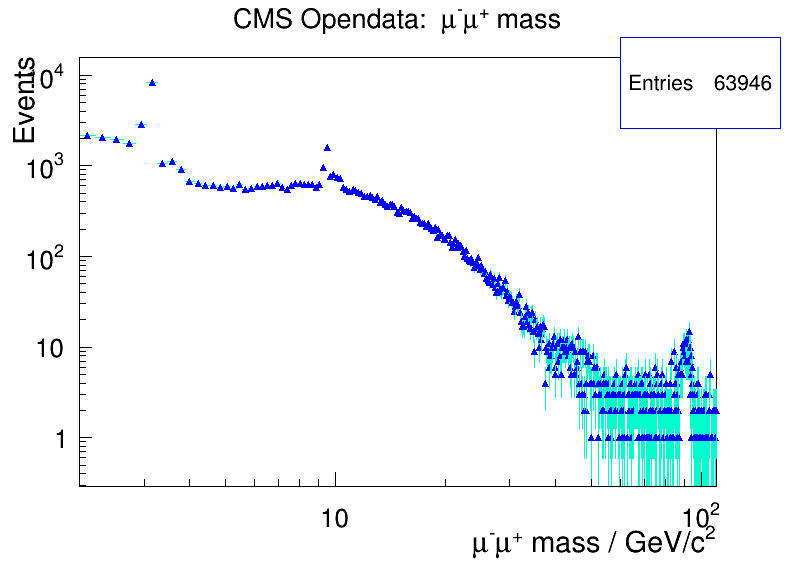

In [2]:
   auto oppositeChargeCut = [](Long64_t Q1, Long64_t Q2){return Q1 * Q2 < 0;};
   auto filteredEvents =  rdf.Filter(oppositeChargeCut, {"Q1", "Q2"})
         .Define("m", "sqrt(pow(E1 + E2, 2) - (pow(px1 + px2, 2) + pow(py1 + py2, 2) + pow(pz1 + pz2, 2)))");

   // Next we create a histogram to hold the invariant mass values and we draw it.
   auto invMass =
      filteredEvents.Histo1D({"invMass", "CMS Opendata: #mu^{-}#mu^{+} mass;#mu^{-}#mu^{+} mass / GeV/c^{2};Events", 512, 2, 110}, "m");

   auto c = new TCanvas();
   c->SetLogy();
   c->SetLogx();
   invMass->Draw();
   c->Draw();  

What resonances are you seeing?